In [81]:
import sys
import scipy.io
import numpy as np
sys.path.append('../src')
import pandas as pd
import matplotlib.pyplot as plt
from mvt_brr import MVTModel
import scipy.optimize as opt
from scipy.stats import pearsonr

In [41]:
data = scipy.io.loadmat('../leheron_trialbytrial/leheron_blockSwitchIndex.mat')
block_order_df = pd.read_csv('../leheron_trialbytrial/leheron_blockOrder.csv')
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")

In [13]:
block_switch_index = data['blockSwitchIndex']
n_subjects = block_switch_index.shape[1]

In [36]:
block_order_df.iloc[0,]

1    1
2    2
Name: 0, dtype: int64

In [55]:
# for i in range(n_subjects):
#     # Access the i-th subject's data, which is in the form of a 2D array
#     subject_data = block_switch_index[0, i]
    
#     # Flatten the subject data array to 1D if needed
#     subject_data = subject_data.flatten()
    
#     print(f"Subject {i+1}:\nTrial length: {len(subject_data)}")
#     # print(subject_data)
#     block_switches = np.where(subject_data == 1)[0]  # Find indices where block switches occur (value is 1)
#     if block_order_df.iloc[0, 0] == 1:
#         print(f"Rich->Poor at {block_switches[-1]+1} timestep")
#     else:
#         print(f"Poor->Rich at {block_switches[-1]+1} timestep")

23 July

In [43]:
df_trials.head(5)

,sub,patch,env,leaveT,meanLT,dmLeave
0,1,3,1,45.034784,40.532927,4.501856
1,1,2,1,44.403900,40.532927,3.870973
2,1,3,1,61.168672,40.532927,20.635745
3,1,1,1,26.803514,40.532927,-13.729413
4,1,3,1,56.992002,40.532927,16.459075


In [45]:
grouped_df = df_trials.groupby(['env', 'patch']).agg(
    mean_leaveT=('leaveT','mean'),
    sd_leaveT=('leaveT', 'std')
).reset_index()

print(grouped_df)

   env  patch  mean_leaveT  sd_leaveT
0    1      1    11.137706   6.020383
1    1      2    15.051354   6.435201
2    1      3    19.709716   7.450578
3    2      1    14.309812   6.639575
4    2      2    18.947625   7.008822
5    2      3    23.441306   7.471792


In [57]:
model = MVTModel(decay_type='exponential')
MVT_rich, MVT_poor = model.run()

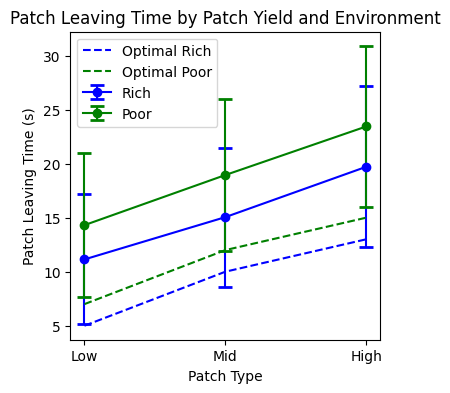

In [61]:
envs = grouped_df['env'].unique()

colors = {1: 'blue', 2: 'green'}
labels = {1: 'Rich', 2:'Poor'}

plt.figure(figsize=(4, 4))

for env in envs:
    env_data = grouped_df[grouped_df['env']==env]

    plt.errorbar(
        env_data['patch'],
        env_data['mean_leaveT'],
        yerr=env_data['sd_leaveT'],
        fmt='o-',
        capsize = 5,
        capthick = 2,
        color = colors[env],
        label = labels[env]
    )
plt.plot([1, 2, 3], MVT_rich, 'b--', label='Optimal Rich')
plt.plot([1, 2, 3], MVT_poor, 'g--', label='Optimal Poor')
plt.xticks([1, 2, 3], ['Low', "Mid", "High"])

plt.xlabel('Patch Type')
plt.ylabel('Patch Leaving Time (s)')
plt.title('Patch Leaving Time by Patch Yield and Environment')
plt.legend()
# plt.legend(title='Subjects')

plt.show()

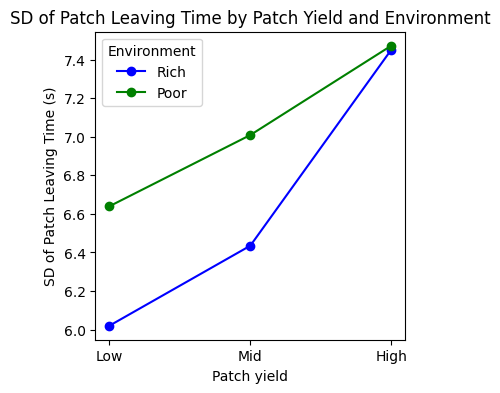

In [62]:
# Create a plot for each environment
plt.figure(figsize=(4, 4))

for env in envs:
    env_data = grouped_df[grouped_df['env'] == env]
    
    # Plot the variance data
    plt.plot(
        env_data['patch'], 
        env_data['sd_leaveT'], 
        'o-', 
        color=colors[env],
        label=labels[env]
    )

# Set the x-axis ticks and labels to ensure correct order
plt.xticks([1, 2, 3], ['Low', 'Mid', 'High'])

# Add labels and title
plt.xlabel('Patch yield')
plt.ylabel('SD of Patch Leaving Time (s)')
plt.title('SD of Patch Leaving Time by Patch Yield and Environment')
plt.legend(title='Environment')

# Show the plot
plt.show()

### Model Fitting

In [100]:
participant_data = df_trials[df_trials["sub"]==1]
patches = participant_data['patch'].values
patches

array([3, 2, 3, 1, 3, 2, 1, 3, 3, 2, 1, 3, 1, 1, 2, 1, 3, 2, 2, 1, 3, 1,
       1, 2, 3, 1, 2])

In [95]:
from world import Patch, Agent
from simulation import Simulation

In [96]:
beta, intercept = 0.2, -3
agent = Agent(beta, intercept)
sim = Simulation(decay_rate=0.075, model='softmax')


In [111]:
simulated_leave_times = {1: [], 2: [], 3: []}
for patch_type in patches:
    patch_id = sim.patch_types[patch_type - 1]
    leave_times = sim.simulate(patch_id, agent, n_runs=1, n_max=100)
    simulated_leave_times[patch_type].append(leave_times[0])

In [112]:
simulated_leave_times

{1: [10, 9, 5, 11, 5, 1, 5, 2, 5, 8],
 2: [7, 13, 15, 8, 6, 12, 6, 8],
 3: [14, 15, 16, 8, 11, 12, 12, 8, 11]}

In [244]:
class Agent:
    def __init__(self, beta=1.0, intercept=0, omega=0.5):
        self.beta = beta
        self.intercept = intercept
        self.omega = omega

    # Softmax policy
    def leave_proba_softmax(self, reward):
        """ Compute the probability of leaving given the reward using softmax. """
        return 1 / (1 + np.exp(self.intercept + self.beta * reward))

    def choose_action_softmax(self, reward):
        leave_proba = self.leave_proba_softmax(reward)
        # Check if leave_proba is a list of one element
        if isinstance(leave_proba, np.ndarray) and len(leave_proba) == 1:
            leave_proba = leave_proba[0]
        return np.random.choice([0, 1], p=[1-leave_proba, leave_proba])  # 0: stay, 1: leave

In [245]:
def combined_error(beta, patch_types, observed_leave, intercept):
    # beta, intercept = params
    agent = Agent(beta=beta, intercept=intercept)
    sim = Simulation(decay_rate=0.075, model='softmax')
    
    simulated_leave_times = []
    for patch_type in patch_types:
        patch_id = sim.patch_types[patch_type-1]
        leave_times = sim.simulate(patch_id, agent, n_runs=1)
        simulated_leave_times.extend(leave_times)
    # print(len(simulated_leave_times))
    mean_simulated_leave = np.mean(simulated_leave_times)
    mean_observed_leave = np.mean(observed_leave)
    error = np.abs(mean_simulated_leave - mean_observed_leave)

    # rmse = np.sqrt(np.mean((np.array(simulated_leave_times) - np.array(observed_leave)) ** 2))
    return error

In [247]:
# Fit model for each environment
environments = df_trials['env'].unique()
results = []

# Define the constant intercept
constant_intercept = -3

for env in environments:
    env_data = df_trials[df_trials['env'] == env]
    participants = env_data['sub'].unique()
    
    for participant in participants:
        participant_data = env_data[env_data['sub'] == participant]
        patches = participant_data['patch'].values
        leave_times = participant_data['leaveT'].values

        # Initial guess for beta
        initial_beta = 0.3

        # Optimize for RMSE using the correct simulation with a constant intercept
        res_combined = opt.minimize(combined_error, initial_beta, method='nelder-mead', args=(patches, leave_times, constant_intercept), options={'xatol': 1e-6, 'disp': True})

        results.append({
            'environment': env,
            'participant': participant,
            'beta_combined': res_combined.x[0],
            'intercept_combined': constant_intercept,
            'rmse': res_combined.fun
        })

/var/folders/fp/j9ldfbxj2_gflf_hz4bf_wyc0000gn/T/ipykernel_944/1392537466.py:21: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res_combined = opt.minimize(combined_error, initial_beta, method='nelder-mead', args=(patches, leave_times, constant_intercept), options={'xatol': 1e-6, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.002288
         Iterations: 65
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 0.006998
         Iterations: 39
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 0.012954
         Iterations: 50
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 0.038664
         Iterations: 27
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 0.008710
         Iterations: 20
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 0.002227
         Iterations: 71
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 0.074885
         Iterations: 16
         Function evaluations: 44
Optimization terminated succes

In [248]:
results_df = pd.DataFrame(results)
print(results_df)

    environment  participant  beta_combined  intercept_combined       rmse
0             1            1       0.301055                  -3  28.294338
1             1            2       0.193125                  -3   0.002288
2             1            3       0.307471                  -3   0.006998
3             1            4       0.232471                  -3   0.012954
4             1            5       0.315000                  -3   7.900234
..          ...          ...            ...                 ...        ...
73            2           35       0.337500                  -3   0.062457
74            2           36       0.296719                  -3   3.365918
75            2           37       0.367441                  -3   0.091320
76            2           38       0.304219                  -3   0.186691
77            2           39       0.347871                  -3   2.493343

[78 rows x 5 columns]


In [260]:
rich_data = df_trials[df_trials['env'] == 1]
rich_sub_1 = rich_data[rich_data['sub'] == 2]
# print(rich_sub_1)

mean_rich_1 = rich_sub_1.groupby(['patch']).agg(mean_leaveT=('leaveT', 'mean'), mean_model_leaveT=('model_leaveT', 'mean')).reset_index()
print(mean_rich_1)

poor_data = df_trials[df_trials['env'] == 2]
poor_sub_1 = poor_data[poor_data['sub'] == 2]


mean_poor_1 = poor_sub_1.groupby(['patch']).agg(mean_leaveT=('leaveT', 'mean'), mean_model_leaveT=('model_leaveT', 'mean')).reset_index()
print(mean_poor_1)

   patch  mean_leaveT  mean_model_leaveT
0      1     6.694433           6.427143
1      2     9.952141          10.457273
2      3    14.034431          13.815294
   patch  mean_leaveT  mean_model_leaveT
0      1     9.289800           7.645882
1      2    11.058539          12.019091
2      3    14.184871          15.155714


In [249]:
# Recalculate model leaving times with optimized parameters
def calculate_model_leaveT(row, results_df):
    participant_result = results_df[(results_df['participant'] == row['sub']) & (results_df['environment'] == row['env'])]
    beta = participant_result['beta_combined'].values[0]
    intercept = participant_result['intercept_combined'].values[0]
    agent = Agent(beta=beta, intercept=intercept)
    sim = Simulation(decay_rate=0.075, model='softmax')
    env = sim.patch_types[int(row['patch'])-1]
    leave_times = sim.simulate(env, agent, n_runs=100)
    return np.mean(leave_times)

In [250]:
df_trials['model_leaveT'] = df_trials.apply(calculate_model_leaveT, axis=1, results_df=results_df)

In [251]:
mean_times = df_trials.groupby(['sub', 'env']).agg(mean_leaveT=('leaveT', 'mean'), mean_model_leaveT=('model_leaveT', 'mean')).reset_index()
mean_times

,sub,env,mean_leaveT,mean_model_leaveT
0,1,1,47.294338,16.844167
1,1,2,34.997398,15.168000
2,2,1,11.283426,11.282286
3,2,2,10.824704,10.522286
4,3,1,16.733743,17.509259
...,...,...,...,...
73,37,2,19.174653,17.468750
74,38,1,16.645795,16.637037
75,38,2,16.648229,14.898077
76,39,1,19.894120,17.674783


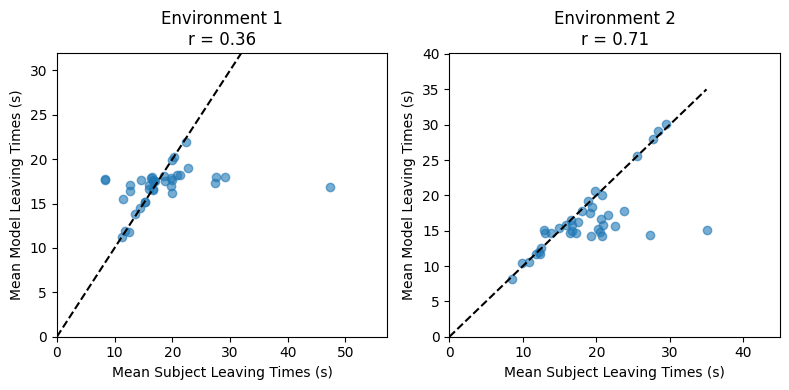

In [252]:
# Plot comparison
plt.figure(figsize=(8, 4))

for i, env in enumerate(environments, 1):
    env_data = mean_times[mean_times['env'] == env]
    
    plt.subplot(1, len(environments), i)
    plt.scatter(env_data['mean_leaveT'], env_data['mean_model_leaveT'], alpha=0.6)
    plt.plot([0, env_data['mean_leaveT'].max()], [0, env_data['mean_leaveT'].max()], 'k--')
    
    # Calculate correlation coefficient
    r, _ = pearsonr(env_data['mean_leaveT'], env_data['mean_model_leaveT'])
    
    plt.xlabel('Mean Subject Leaving Times (s)')
    plt.ylabel('Mean Model Leaving Times (s)')
    plt.title(f'Environment {env}\nr = {r:.2f}')
    plt.xlim(0, env_data['mean_leaveT'].max() + 10)
    plt.ylim(0, env_data['mean_model_leaveT'].max() + 10)

plt.tight_layout()
plt.show()

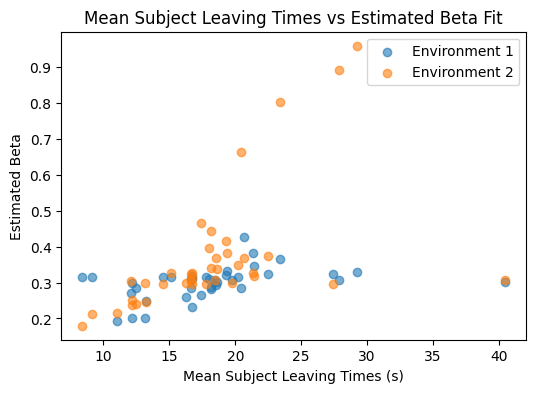

In [253]:
# Calculate mean leaving times per participant
mean_leaving_times = df_trials.groupby('sub')['leaveT'].mean().reset_index()
mean_leaving_times.columns = ['participant', 'mean_leaveT']

# Merge with the results_df to get the beta values
merged_df = pd.merge(results_df, mean_leaving_times, left_on='participant', right_on='participant')

# Plot the mean leaving times vs estimated beta fit
plt.figure(figsize=(6, 4))

for env in merged_df['environment'].unique():
    env_data = merged_df[merged_df['environment'] == env]
    plt.scatter(env_data['mean_leaveT'], env_data['beta_combined'], label=f'Environment {env}', alpha=0.6)

plt.xlabel('Mean Subject Leaving Times (s)')
plt.ylabel('Estimated Beta')
plt.title('Mean Subject Leaving Times vs Estimated Beta Fit')
plt.legend()
plt.show()